# Generate Training Data

In order to train the discriminative models, we need training data. To this end, we create synthetic training data via a simple simulation of kicks on goal. The algorithm works as follows:

- Divide the goal up into equally-spaced regions
- Draw a grid around the goal
- Go through this grid and generate a kick that will land exactly there
- Labels are `wide-left`, `shot`, and `wide-right`

### 2D Deterministic Data Generator

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


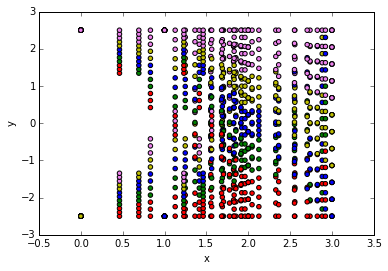

In [23]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['x', 'y', 'dx', 'dy', 'label'])
World = namedtuple('World', ['goal', 'end'])

class_names = ('wide_left', 'shot_left', 'shot_center', 'shot_right', 'wide_right')
classes = {class_name:i for i, class_name in enumerate(class_names)}

def get_label(y):
    """Return the class which y falls in
    
    This amount to returning the index corresponding to the region that y is crossing the plane at
    
    """
    wide_left, left_center, center_right, right_wide = -1.5, -.5, .5, 1.5
    
    if y < wide_left:
        return classes['wide_left']
    elif wide_left <= y < left_center:
        return classes['shot_left']
    elif left_center <= y <= center_right:
        return classes['shot_center']
    elif center_right < y <= right_wide:
        return classes['shot_right']
    elif right_wide < y:
        return classes['wide_right']
    else:
        raise AssertionError(y)

def data_generator(num_starts=1, num_xs_start=2, num_ys_start=2, num_xs_end=2, num_ys_end=2, time_steps=10, decay=.8):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_xs_start : int
    The number of starting x points you want
    
    num_ys_start : int
    The number of starting y points you want
    
    num_xs_end : int
    The number of ending points in the x direction you want
    
    num_ys_end : int
    The number of ending points in the y direction you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """    
    # Hard-code a single starting point
    xs_start, ys_start = np.linspace(0, 1, num_xs_start), np.linspace(-2.5, 2.5, num_ys_start)
    starts = itertools.product(xs_start, ys_start)
    
    # Create grid of end points
    xs_end, ys_end = np.linspace(2, 3, num_xs_end), np.linspace(-2.5, 2.5, num_ys_end)
    ends = itertools.product(xs_end, ys_end)
    
    for (x_start, y_start), (x_end, y_end) in itertools.product(starts, ends):
        # Find the region in which the shot is destined for and get the label
        slope = (y_end-y_start) / (x_end-x_start)
        y = slope*(2-x_start) + y_start
        label = get_label(y)

        # Starting velocities to reach the destination
        c = (1-decay) / (1-decay**(time_steps-1))
        dx_start = c * (x_end-x_start)
        dy_start = c * (y_end-y_start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        x_velocities = decays * dx_start
        y_velocities = decays * dy_start

        # Distance traveled at each time step
        x_deltas = np.cumsum(x_velocities)
        y_deltas = np.cumsum(y_velocities)

        # Compute the actual points given deltas
        x_positions = x_start + x_deltas
        x_positions = np.append([x_start], x_positions[:-1])
        y_positions = y_start + y_deltas
        y_positions = np.append([y_start], y_positions[:-1])
        
        # Yield the points one by one
        for x, y, dx, dy in zip(x_positions, y_positions, x_velocities, y_velocities):
            yield State(x, y, dx, dy, label)


data_points = data_generator(num_ys_end=12)
data_points = list(data_points)
labels = np.array([data_point.label for data_point in data_points])

colormap = np.array(['r', 'g', 'b', 'y', 'violet'])

df = pd.DataFrame(data_points, columns=State._fields)
df.plot(kind='scatter', x='x', y='y', c=colormap[labels])

### Class Numbers

In [24]:
df.groupby('label').size()

label
0    210
1    170
2    200
3    170
4    210
dtype: int64

### Filter Away Points out of Goalie's Field of View

label
0    151
1    112
2    122
3    112
4    151
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


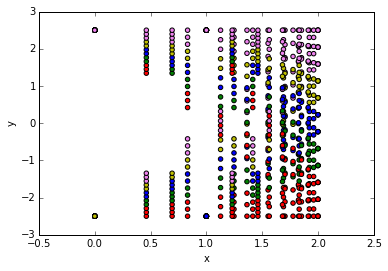

In [25]:
data_points = [data_point for data_point in data_points if not data_point.x > 2]

data_points_2d = pd.DataFrame(data_points, columns=State._fields)

# Plot it
labels = data_points_2d['label']
colormap = np.array(['r', 'g', 'b', 'y', 'violet'])
data_points_2d.plot(kind='scatter', x='x', y='y', c=colormap[labels])
 
data_points_2d.groupby('label').size()

### Restore Class Balance

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


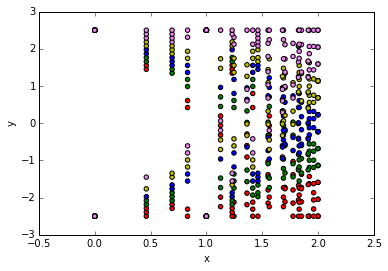

In [26]:
groups = data_points_2d.groupby('label')

def filter_down(group):
    """Filters down a pandas groupby object to a specified number"""
    
    size = len(group)
    mask = np.full(size, False, bool)
    lucky_indices = np.random.choice(size, 100, replace=False)
    mask[lucky_indices] = True
    
    return group[mask]

many_many_long = groups.apply(filter_down)

# Plot it
labels = many_many_long['label']
colormap = np.array(['r', 'g', 'b', 'y', 'violet'])
many_many_long.plot(kind='scatter', x='x', y='y', c=colormap[labels])

In [27]:
many_many_long.groupby('label').size()

label
0    100
1    100
2    100
3    100
4    100
dtype: int64

In [28]:
%store many_many_long

Stored 'many_many_long' (DataFrame)
